In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier


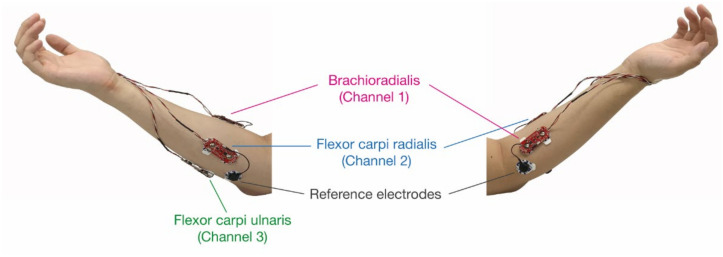

In [2]:
SAMPLE_RATE = 250  # Hz
CUTOFF_FREQ = 20.  # Hz high-pass cutoff
SAVE_FILE = "data/emg_handposes/sub-01/ses-02/emg_trial_data.pkl"

In [3]:
with open(SAVE_FILE, "rb") as f:
    trial_results = pickle.load(f)

print("Total number of trials:", len(trial_results))
print("Keys in the first trial:", trial_results[0].keys())

Total number of trials: 80
Keys in the first trial: dict_keys(['pose', 'round', 'cycle', 'samples', 'data'])


In [4]:
data_by_label = {}
for trial in trial_results:
    label = trial["pose"]
    if trial["data"] is not None and trial["data"].size > 0:
        data_by_label.setdefault(label, []).append(trial["data"])

for label, trials in data_by_label.items():
    print(f"{label}: {len(trials)} trials")
    print(f"  First trial shape: {trials[0].shape}")

Rest: 40 trials
  First trial shape: (8, 1100)
fist: 10 trials
  First trial shape: (8, 1100)
flat: 10 trials
  First trial shape: (8, 1100)
okay: 10 trials
  First trial shape: (8, 1100)
two: 10 trials
  First trial shape: (8, 1100)


Filter line noise and low frequency drifts

In [5]:
def comb_notch_filter(data, fs=SAMPLE_RATE, fundamental=60, n_harmonics=2, Q=30):
    """Sequentially applies notch filters to remove line noise at the fundamental and its harmonics."""
    filtered_data = np.copy(data)
    for i in range(1, n_harmonics + 1):
        freq = i * fundamental
        if freq < fs / 2:
            b, a = iirnotch(freq, Q, fs)
            filtered_data = filtfilt(b, a, filtered_data, axis=1)
    return filtered_data

def highpass_filter(data, cutoff, fs=SAMPLE_RATE, order=4):
    """Applies a Butterworth high-pass filter along axis=1."""
    nyquist = 0.5 * fs
    normalized_cutoff = cutoff / nyquist
    b, a = butter(order, normalized_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data, axis=1)

In [6]:
'''
for label, trials in data_by_label.items():
    for i in range(len(trials)):
        if trials[i].size > 0:
            filtered = comb_notch_filter(trials[i], fs=SAMPLE_RATE, fundamental=60, n_harmonics=2, Q=30)
            #trials[i] = filtered
            #trials[i] = highpass_filter(filtered, cutoff=CUTOFF_FREQ, fs=SAMPLE_RATE, order=4)
print("Filtering complete.")
'''

'\nfor label, trials in data_by_label.items():\n    for i in range(len(trials)):\n        if trials[i].size > 0:\n            filtered = comb_notch_filter(trials[i], fs=SAMPLE_RATE, fundamental=60, n_harmonics=2, Q=30)\n            #trials[i] = filtered\n            #trials[i] = highpass_filter(filtered, cutoff=CUTOFF_FREQ, fs=SAMPLE_RATE, order=4)\nprint("Filtering complete.")\n'

Choose channels we recorded from 

In [9]:
selected_channels = [0, 3, 6]

for label, trials in data_by_label.items():
    for i in range(len(trials)):
        trial_data = trials[i]
        trials[i] = trial_data[selected_channels, :]

# Verify the channel selection:
for label, trials in data_by_label.items():
    print(f"{label}: {len(trials)} trials")
    print(f"  First trial shape after channel selection: {trials[0].shape}")


Rest: 40 trials
  First trial shape after channel selection: (3, 1100)
fist: 10 trials
  First trial shape after channel selection: (3, 1100)
flat: 10 trials
  First trial shape after channel selection: (3, 1100)
okay: 10 trials
  First trial shape after channel selection: (3, 1100)
two: 10 trials
  First trial shape after channel selection: (3, 1100)


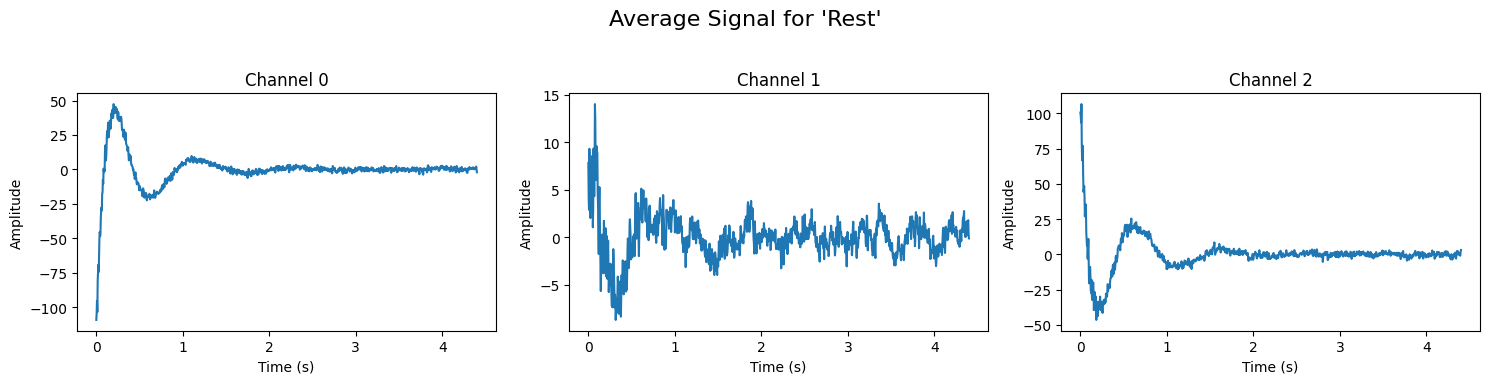

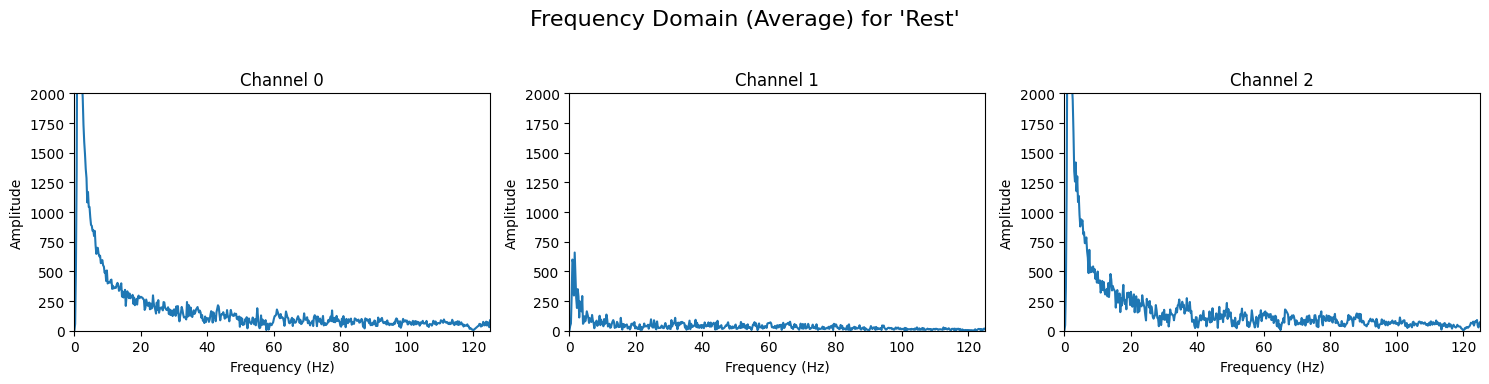

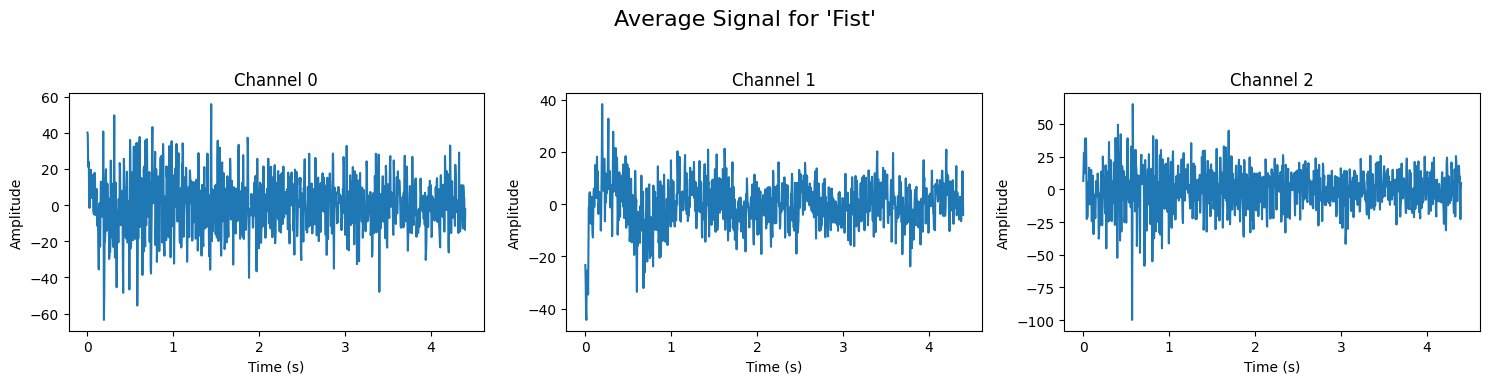

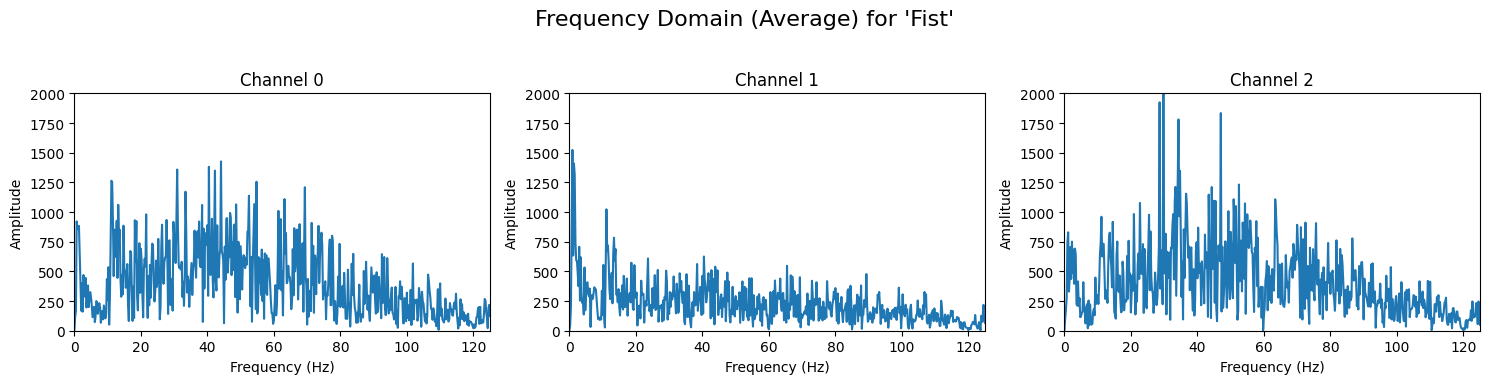

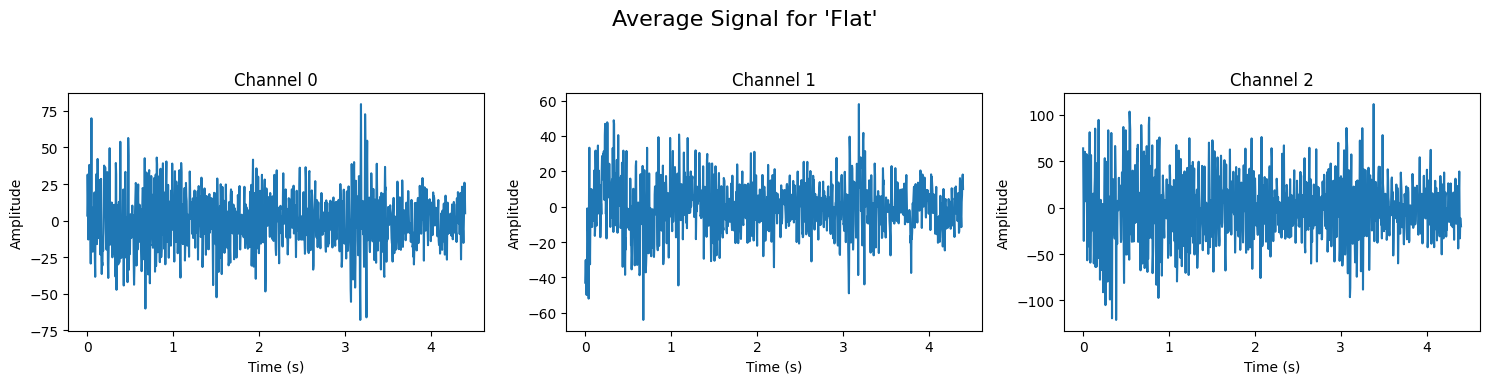

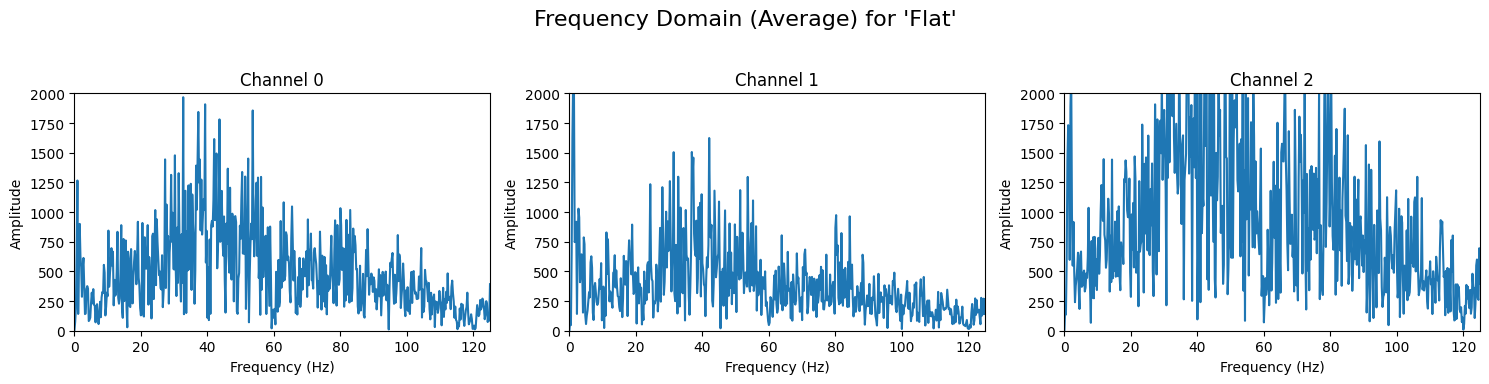

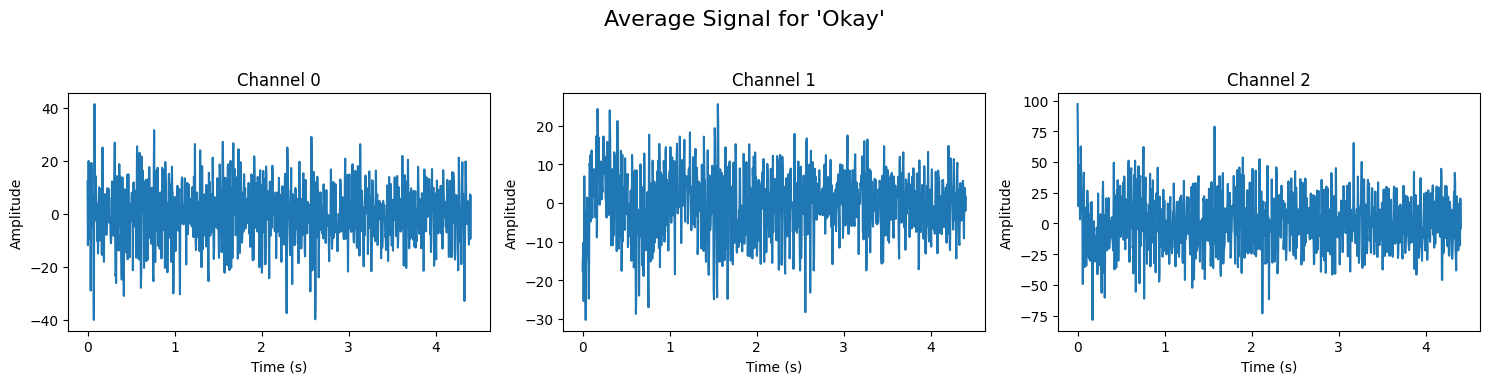

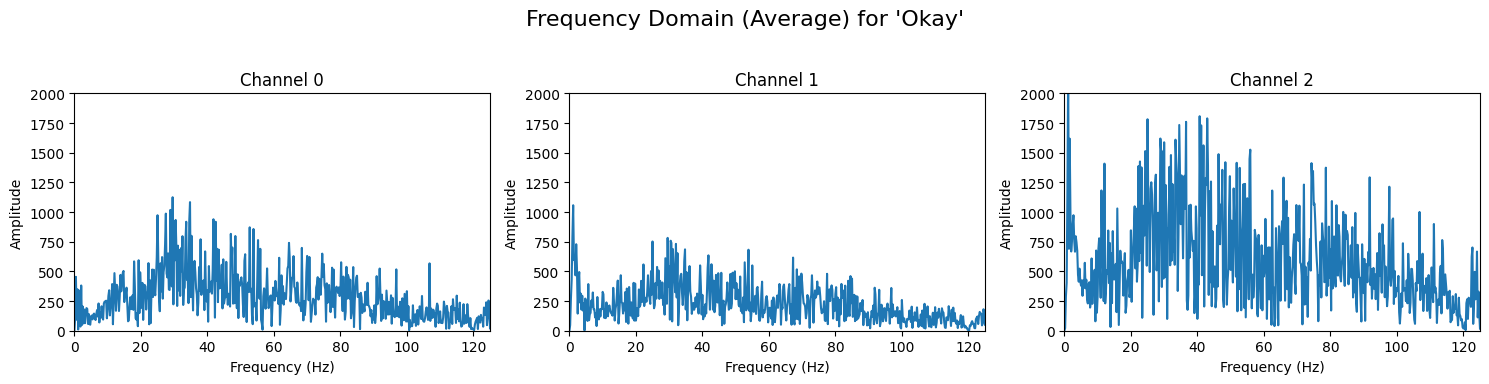

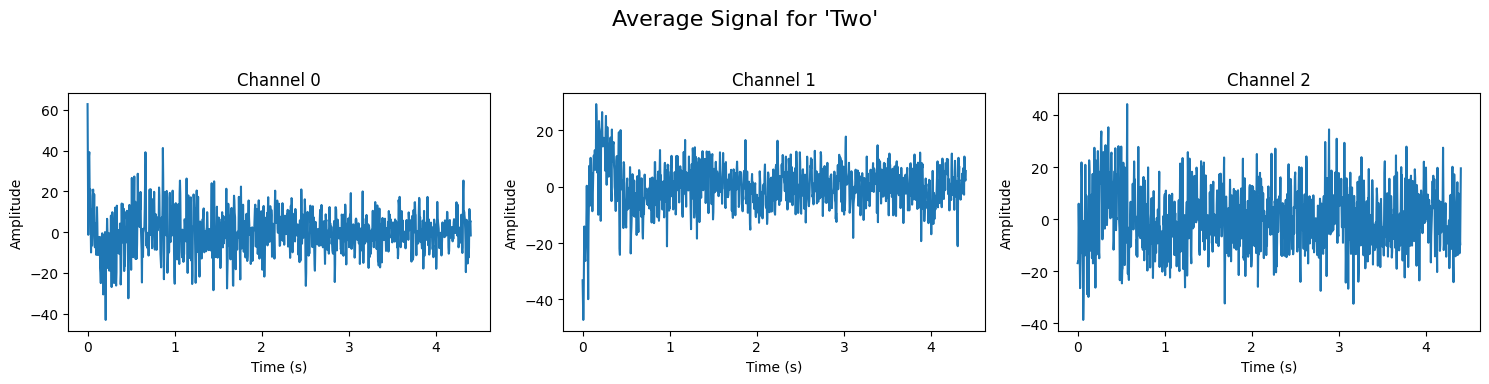

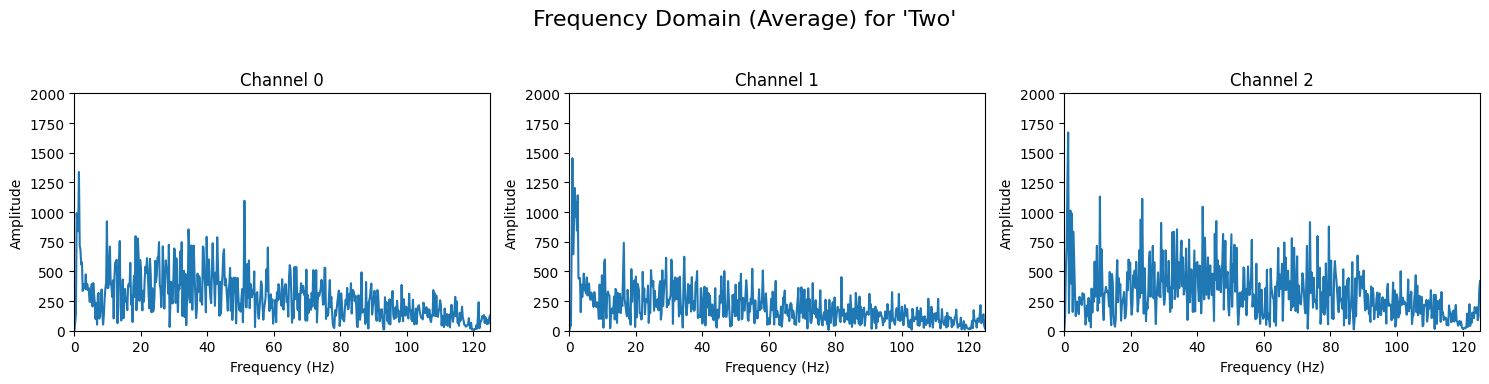

In [10]:
# Visualization: Plot time-domain and frequency-domain averages for each label
for label, trials in data_by_label.items():
    # Align trials to the minimum length in this label
    min_samples = min(trial.shape[1] for trial in trials)
    aligned_trials = np.array([trial[:, :min_samples] for trial in trials])

    # Time-domain average signal
    avg_signal = np.mean(aligned_trials, axis=0)
    time_axis = np.linspace(0, min_samples / SAMPLE_RATE, min_samples)

    fig, axs = plt.subplots(1, avg_signal.shape[0], figsize=(15, 4), sharex=True)
    fig.suptitle(f"Average Signal for '{label.capitalize()}'", fontsize=16)

    for ch in range(avg_signal.shape[0]):
        axs[ch].plot(time_axis, avg_signal[ch])
        axs[ch].set_title(f"Channel {ch}")
        axs[ch].set_xlabel("Time (s)")
        axs[ch].set_ylabel("Amplitude")
        #axs[ch].set_ylim([-75, 75])  # Fixed y-axis limits for time domain

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Frequency-domain plot (remove DC offset first)
    # We modify 'avg_signal' in place, so if you want to preserve it, make a copy
    for ch in range(avg_signal.shape[0]):
        avg_signal[ch] -= np.mean(avg_signal[ch])
    freqs = np.fft.rfftfreq(min_samples, d=1/SAMPLE_RATE)
    fft_channels = [np.abs(np.fft.rfft(avg_signal[ch])) for ch in range(avg_signal.shape[0])]

    fig, axs = plt.subplots(1, avg_signal.shape[0], figsize=(15, 4), sharex=True)
    fig.suptitle(f"Frequency Domain (Average) for '{label.capitalize()}'", fontsize=16)

    for ch in range(avg_signal.shape[0]):
        axs[ch].plot(freqs, fft_channels[ch])
        axs[ch].set_title(f"Channel {ch}")
        axs[ch].set_xlabel("Frequency (Hz)")
        axs[ch].set_ylabel("Amplitude")
        axs[ch].set_xlim([0, 125])
        axs[ch].set_ylim([0, 2000])  # Fixed y-axis limits for frequency domain

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


Window the data into smaller windows for each original 4.2 second section of pose data.

I chose 0.42 since it divides the original sequence into 10 smaller windows but this can be changed to however we want. 

In [11]:
window_length_sec = 1
window_length = int(window_length_sec* SAMPLE_RATE)
overlap = 0
step = max(1, int(window_length * (1 - overlap)))  # step size

X_windowed, y_windowed = [], []
for label, trials in data_by_label.items():
    for trial in trials:
        if trial.size > 0:
            n_samples = trial.shape[1]
            for start in range(0, n_samples - window_length + 1, step):
                X_windowed.append(trial[:, start:start + window_length])
                y_windowed.append(label)


In [12]:
label_map = {"fist": 0, "flat": 1, "okay": 2, "two": 3, "Rest": 4}
y_windowed_int = [label_map[lbl] for lbl in y_windowed]
X_final = np.array(X_windowed)
y_final = np.array(y_windowed_int)
print("Final dataset shape:", X_final.shape)
print("Final labels shape:", y_final.shape)

Final dataset shape: (320, 3, 250)
Final labels shape: (320,)


In [13]:
print(Counter(y_final))

Counter({4: 160, 0: 40, 1: 40, 2: 40, 3: 40})


Since we end up recording rest for every single hand pose, we have 4 times the amount of rest classes in our data. In order to address this we can downsample the rest class. I did this by randomly selecting rest windows.

In [14]:
import random

# Example: Suppose you have X_list, y_list for your entire dataset
# X_list : list (or array) of feature vectors
# y_list : list of class labels (integers)

target_label = 4  # The class you want to downsample (e.g. 'rest')
# We'll downsample "rest" to match the smallest of the other classes

# 1) Group data by label
from collections import defaultdict
class_data = defaultdict(list)
for x, label in zip(X_final, y_final):
    class_data[label].append(x)

# 2) Find how many samples you want to keep from the target label.
#    For example, match the smallest class among the *other* labels.
min_other_class_size = min(len(samples)
                           for lbl, samples in class_data.items()
                           if lbl != target_label)

# 3) Build balanced dataset
X_balanced = []
y_balanced = []

for lbl, samples in class_data.items():
    if lbl == target_label:
        # Downsample the target class
        if len(samples) > min_other_class_size:
            chosen = random.sample(samples, min_other_class_size)
        else:
            chosen = samples
        X_balanced.extend(chosen)
        y_balanced.extend([lbl] * len(chosen))
    else:
        # Keep every sample from other classes
        X_balanced.extend(samples)
        y_balanced.extend([lbl] * len(samples))

# 4) Convert to NumPy arrays (if needed)
X_final = np.array(X_balanced)
y_final = np.array(y_balanced)



The datset is now balanced.

In [15]:
print(Counter(y_final))

Counter({4: 40, 0: 40, 1: 40, 2: 40, 3: 40})


I followed the feature extraction methods they used in this paper https://www.sciencedirect.com/science/article/pii/S0208521617300323 These seem to be quite common across EMG studies and more details about them can be found in the paper. 

In [16]:
def compute_features(signal):
#    rms = np.sqrt(np.mean(signal**2))
#    var = np.var(signal)
    mav = np.mean(np.abs(signal))
    ssc_count = sum(1 for i in range(1, len(signal) - 1)
                    if (signal[i] - signal[i-1]) * (signal[i+1] - signal[i]) < 0)
    zc_count = sum(1 for i in range(len(signal) - 1)
                   if (signal[i] > 0 and signal[i+1] < 0) or (signal[i] < 0 and signal[i+1] > 0))
    wl = np.sum(np.abs(np.diff(signal)))
    return np.array([mav, ssc_count, zc_count, wl])

all_features = []
for window in X_final:  # window.shape = (n_channels, window_length)
    window_features = []
    for ch_signal in window:
        window_features.extend(compute_features(ch_signal))
    all_features.append(window_features)
all_features = np.array(all_features)
print("Feature matrix shape:", all_features.shape)
print("Labels shape:", y_final.shape)

Feature matrix shape: (200, 12)
Labels shape: (200,)


In [17]:
feature_names = ["MAV", "SSC", "ZC", "WL"]
n_channels = X_final.shape[1]
feature_cols = [f"ch{ch}_{feat}" for ch in range(n_channels) for feat in feature_names]

df = pd.DataFrame(all_features, columns=feature_cols)
df["label_int"] = y_final
rev_label_map = {v: k for k, v in label_map.items()}
df["pose"] = df["label_int"].map(rev_label_map)
df


,ch0_MAV,ch0_SSC,ch0_ZC,ch0_WL,ch1_MAV,ch1_SSC,ch1_ZC,ch1_WL,ch2_MAV,ch2_SSC,ch2_ZC,ch2_WL,label_int,pose
0,3.338378,117.0,51.0,458.794606,6.407720,120.0,21.0,494.574138,7.289097,117.0,13.0,482.528139,4,Rest
1,3.876676,124.0,29.0,448.904401,5.784731,131.0,34.0,507.201254,5.491885,124.0,37.0,623.661853,4,Rest
2,2.959941,113.0,38.0,387.962321,5.228516,116.0,37.0,430.954317,4.463519,107.0,17.0,412.740460,4,Rest
3,3.914016,110.0,38.0,470.053776,4.378898,134.0,37.0,481.417513,6.512754,120.0,34.0,638.432329,4,Rest
4,4.151524,130.0,45.0,613.541834,4.439408,128.0,43.0,594.239604,4.685807,120.0,52.0,732.152758,4,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,14.451384,134.0,97.0,4161.354873,11.033005,137.0,96.0,3071.736147,15.439048,143.0,101.0,4503.587686,3,two
196,18.111795,147.0,83.0,4671.030751,13.341792,141.0,104.0,3941.901807,25.618831,135.0,66.0,5695.337797,3,two
197,12.943053,124.0,104.0,3955.340905,10.300064,145.0,95.0,2910.269389,14.005107,147.0,106.0,4327.412802,3,two
198,13.167267,132.0,91.0,3752.090843,10.945228,127.0,75.0,2655.808751,14.584425,140.0,87.0,3809.235023,3,two


In [18]:
excluded_labels = {}
keep_indices = [i for i, lbl in enumerate(y_final) if lbl not in excluded_labels]
features_filtered = all_features[keep_indices]
y_filtered = y_final[keep_indices]

X_train, X_test, y_train, y_test = train_test_split(features_filtered, y_filtered,
                                                    test_size=0.2, random_state=44)

# Standardize features for the classifier
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

label_map = {0: "fist", 1: "flat", 2: "okay", 3: "two", 4:"rest"}
class_names = [label_map[i] for i in sorted(label_map.keys())]

param_grid_svm = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

In [19]:
svm_clf = SVC()
grid_search = GridSearchCV(
    estimator=svm_clf,
    param_grid=param_grid_svm,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

best_svm = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Hyperparameters: {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
Best CV Accuracy: 0.8375


In [20]:
y_pred_svm = best_svm.predict(X_test_scaled)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_svm, target_names=class_names))


Classification Report on Test Set:
              precision    recall  f1-score   support

        fist       0.82      0.90      0.86        10
        flat       0.80      0.50      0.62         8
        okay       0.67      0.86      0.75         7
         two       0.86      0.86      0.86         7
        rest       1.00      1.00      1.00         8

    accuracy                           0.82        40
   macro avg       0.83      0.82      0.82        40
weighted avg       0.83      0.82      0.82        40



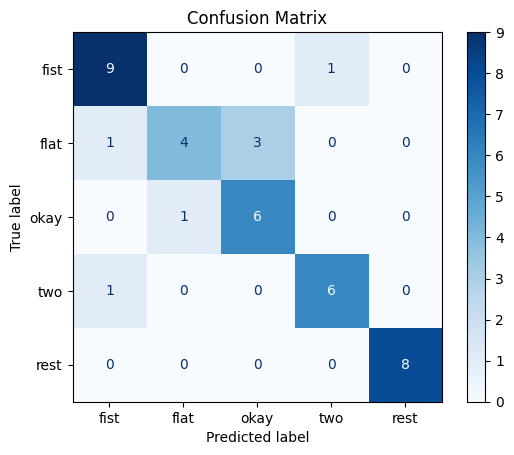

In [21]:
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.title("Confusion Matrix")
plt.show()

In [22]:

knn_clf = KNeighborsClassifier()
grid_search_knn = GridSearchCV(
    estimator=knn_clf,
    param_grid=param_grid_knn,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_knn.fit(X_train_scaled, y_train)

best_knn = grid_search_knn.best_estimator_
print("Best Hyperparameters (kNN):", grid_search_knn.best_params_)
print("Best CV Accuracy (kNN):", grid_search_knn.best_score_)



Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Hyperparameters (kNN): {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
Best CV Accuracy (kNN): 0.78125


In [23]:
y_pred_knn = best_knn.predict(X_test_scaled)
print("\nClassification Report on Test Set (kNN):")
print(classification_report(y_test, y_pred_knn, target_names=class_names))


Classification Report on Test Set (kNN):
              precision    recall  f1-score   support

        fist       0.91      1.00      0.95        10
        flat       0.75      0.38      0.50         8
        okay       0.60      0.86      0.71         7
         two       1.00      1.00      1.00         7
        rest       1.00      1.00      1.00         8

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.83        40
weighted avg       0.86      0.85      0.84        40



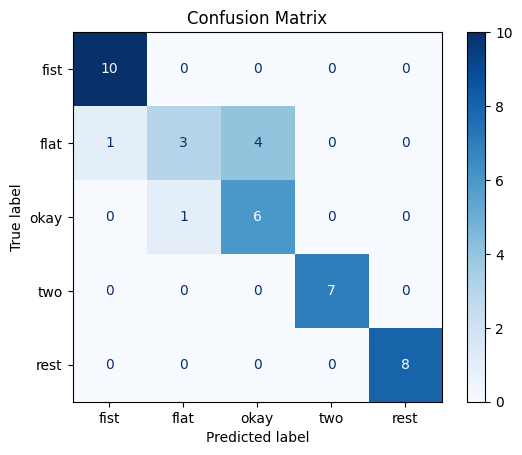

In [24]:
cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.title("Confusion Matrix")
plt.show()

### Adding code to save trained SVM model and scaler for real-time inference 

In [26]:
import pickle

# Save the best SVM model and scaler
with open('trained_model.pkl', 'wb') as f:
    pickle.dump((best_svm, scaler), f)

print("Model and scaler saved as 'trained_model.pkl'.")

Model and scaler saved as 'trained_model.pkl'.


In [29]:
# Verifying the Saved Model
with open('trained_model.pkl', 'rb') as f:
    loaded_model, loaded_scaler = pickle.load(f)

print("Loaded Model:", loaded_model)
print("Loaded Scaler:", loaded_scaler)

Loaded Model: SVC(C=10, gamma=0.001, kernel='linear')
Loaded Scaler: StandardScaler()
